#Python Exercise - Emily Cam

In [49]:
from datetime import datetime, timedelta
import requests
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


Function to get yesterday's date

In [50]:
def get_date():
    today = datetime.now()
    previous_day = today - timedelta(days=1)
    previous_day = previous_day.strftime('%Y-%m-%d')
    return previous_day


Function to generate the API request and get the data

In [51]:
def get_data(data_code):
    # Define the parameters for the request
    VersionNo = 'v1'
    APIKey = '8zk2zdr5wv6zj72'
    SettlementDate = get_date()
    Period = '*'

    url = f'https://api.bmreports.com/BMRS/{data_code}/{VersionNo}?APIKey={APIKey}&SettlementDate={SettlementDate}&Period={Period}&ServiceType=csv'
# Make API requests to get the data
    data = requests.get(url)

# Check if the requests were successful
    if data.status_code == 200:
        # Parse the CSV data into dataframes
        data = pd.read_csv(io.StringIO(data.text), skiprows=2, header=2)
        return data
    else:
        print("API request failed.")


Clean the data to keep only required columns and rows, rename for coding convenience and to have matching Settlement Period column header for future merging

In [52]:
imbalance_prices_data = get_data('B1770')
imbalance_prices_data = imbalance_prices_data[imbalance_prices_data['TimeSeriesID']
                                              == 'ELX-EMFIP-IMBP-TS-1']
imbalance_prices_data = imbalance_prices_data[[
    'ImbalancePriceAmount', 'SettlementPeriod']]
imbalance_prices_data = imbalance_prices_data.rename(
    columns={'ImbalancePriceAmount': 'Imbalance_Price_Amount', 'SettlementPeriod': 'Settlement_Period'})

imbalance_volumes_data = get_data('B1780')
imbalance_volumes_data = imbalance_volumes_data[[
    'Imbalance Quantity (MAW)', 'Settlement Period']]
imbalance_volumes_data = imbalance_volumes_data.rename(
    columns={'Imbalance Quantity (MAW)': 'Imbalance_Quantity_MAW', 'Settlement Period': 'Settlement_Period'})


Function to calculate total daily imbalance cost and daily imbalance unit rate and generate a reporting message

In [53]:
def calc_daily(df1, df2):
    # Merge the datasets by Settlement_Period
    merged_data = pd.merge(df1, df2, on='Settlement_Period')

    # Calculate hourly imbalance costs
    merged_data['Half_Hourly_Imbalance_Cost'] = merged_data['Imbalance_Price_Amount'] * \
        merged_data['Imbalance_Quantity_MAW']

    # Aggregate hourly costs to get daily total imbalance cost
    total_daily_imbalance_cost = merged_data['Half_Hourly_Imbalance_Cost'].sum(
    )

    # Calculate hourly imbalance unit rates
    merged_data['Half_Hourly_Imbalance_Unit_Rate'] = merged_data['Imbalance_Price_Amount'] / \
        merged_data['Imbalance_Quantity_MAW']

    # Calculate daily average imbalance unit rate
    daily_imbalance_unit_rate = merged_data['Half_Hourly_Imbalance_Unit_Rate'].mean(
    )

    print('Total Daily Imbalance Cost = ', total_daily_imbalance_cost)
    print('Daily Imbalance Unit Rate = ', daily_imbalance_unit_rate)

    return merged_data


Function to find the hour with maximum value in chosen column

In [54]:
def id_hour_with_max(df, max_column):
    # Ensure the column used to find the maximum is numeric
    df[max_column] = pd.to_numeric(df[max_column])

    # Make all volumes positive
    df[max_column] = abs(df[max_column])

    # Create a new column 'Hour' by dividing 'Settlement_Period' by 2
    # Round up to the nearest integer
    df['Hour'] = (df['Settlement_Period'] + 1) // 2

    # Group by hour and sum volumes
    df_hourly = df.groupby('Hour')[max_column].sum().reset_index()

    # Find the hour with the highest volume
    hour_with_max = df_hourly[df_hourly[max_column] ==
                              df_hourly[max_column].max()]['Hour'].values[0]

    # Format the hour as a time string
    hour_with_max = f"{int(hour_with_max):02d}:00"

    print('The hour with the highest absolute imbalance volumes is = ', hour_with_max)

    return df_hourly


#Reporting messages

In [55]:
daily_imbalance_reporting = calc_daily(
    imbalance_prices_data, imbalance_volumes_data)
hour_with_max_abs_imbalance_volume_reporting = id_hour_with_max(
    imbalance_volumes_data, 'Imbalance_Quantity_MAW')


Total Daily Imbalance Cost =  830760.3132388499
Daily Imbalance Unit Rate =  -7.92392300672461
The hour with the highest absolute imbalance volumes is =  07:00


In [56]:
daily_imbalance_reporting


,Imbalance_Price_Amount,Settlement_Period,Imbalance_Quantity_MAW,Half_Hourly_Imbalance_Cost,Half_Hourly_Imbalance_Unit_Rate
0,118.00000,48.0,156.1185,18421.983000,0.755836
1,130.00000,47.0,103.9693,13516.009000,1.250369
2,134.45000,46.0,172.0602,23133.493890,0.781413
3,125.00000,45.0,46.2852,5785.650000,2.700647
4,43.64000,44.0,-369.6186,-16130.155704,-0.118068
5,43.62000,43.0,-160.2224,-6988.901088,-0.272247
6,50.00000,42.0,-39.5453,-1977.265000,-1.264373
7,43.55000,41.0,-87.8634,-3826.451070,-0.495656
8,135.90000,40.0,179.3159,24369.030810,0.757880
9,138.00000,39.0,390.1892,53846.109600,0.353675


In [57]:
hour_with_max_abs_imbalance_volume_reporting


,Hour,Imbalance_Quantity_MAW
0,1.0,133.2754
1,2.0,535.3484
2,3.0,366.5350
3,4.0,366.7721
4,5.0,626.9044
5,6.0,221.7911
6,7.0,1572.3222
7,8.0,418.3264
8,9.0,235.2645
9,10.0,60.4421


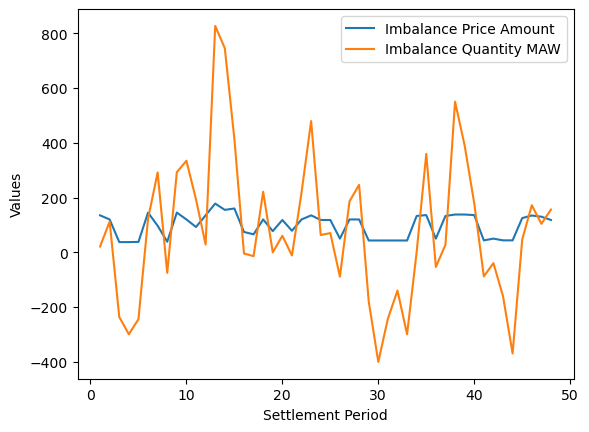

In [58]:
x = daily_imbalance_reporting['Settlement_Period']
y_price_amount = daily_imbalance_reporting['Imbalance_Price_Amount']
y_quantity_maw = daily_imbalance_reporting['Imbalance_Quantity_MAW']

fig, ax = plt.subplots()

ax.plot(x, y_price_amount, label='Imbalance Price Amount')
ax.plot(x, y_quantity_maw, label='Imbalance Quantity MAW')

ax.set_xlabel('Settlement Period')
ax.set_ylabel('Values')
ax.legend()

plt.show()


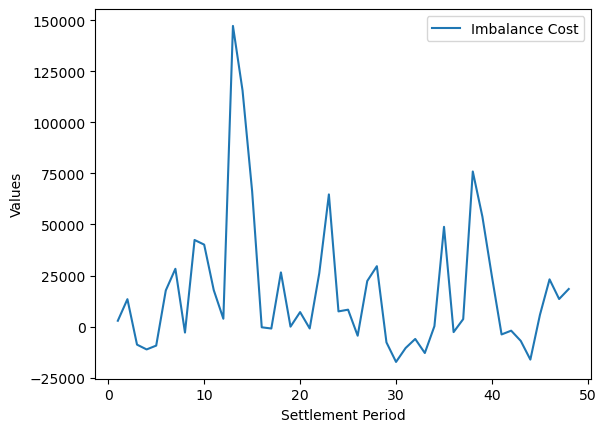

In [59]:
x = daily_imbalance_reporting['Settlement_Period']
y_cost = daily_imbalance_reporting['Half_Hourly_Imbalance_Cost']
fig, ax = plt.subplots()

ax.plot(x, y_cost, label='Imbalance Cost')

ax.set_xlabel('Settlement Period')
ax.set_ylabel('Values')
ax.legend()

plt.show()


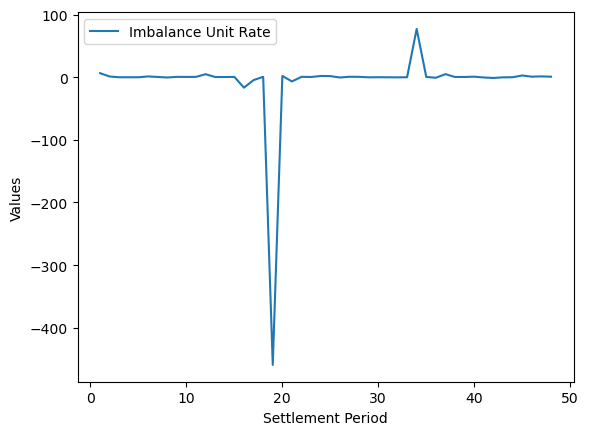

In [60]:
x = daily_imbalance_reporting['Settlement_Period']
y_unit_rate = daily_imbalance_reporting['Half_Hourly_Imbalance_Unit_Rate']
fig, ax = plt.subplots()

ax.plot(x, y_unit_rate, label='Imbalance Unit Rate')

ax.set_xlabel('Settlement Period')
ax.set_ylabel('Values')
ax.legend()

plt.show()


Pearson Correlation Coefficient: 0.83
P-Value: 0.0000


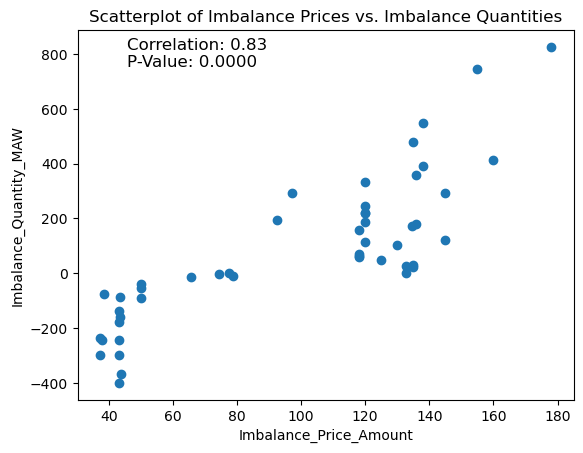

In [61]:
X = daily_imbalance_reporting['Imbalance_Price_Amount']
Y = daily_imbalance_reporting['Imbalance_Quantity_MAW']

plt.scatter(X, Y)
plt.xlabel('Imbalance_Price_Amount')
plt.ylabel('Imbalance_Quantity_MAW')
plt.title('Scatterplot of Imbalance Prices vs. Imbalance Quantities')
correlation, p_value = pearsonr(X, Y)
print(f'Pearson Correlation Coefficient: {correlation:.2f}')
print(f'P-Value: {p_value:.4f}')
plt.annotate(f'Correlation: {correlation:.2f}\nP-Value: {p_value:.4f}',
             xy=(0.1, 0.9), xycoords='axes fraction', fontsize=12)

plt.show()


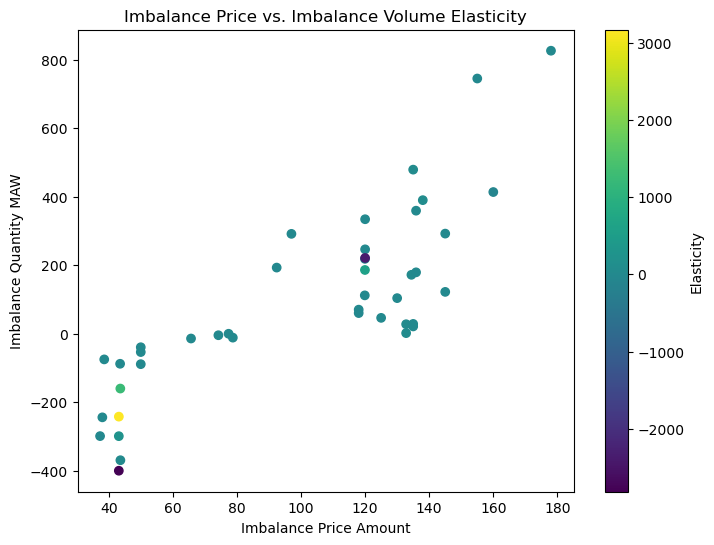

In [62]:
daily_imbalance_reporting['Price_Percent_Change'] = daily_imbalance_reporting['Imbalance_Price_Amount'].pct_change() * \
    100
daily_imbalance_reporting['Volume_Percent_Change'] = daily_imbalance_reporting['Imbalance_Quantity_MAW'].pct_change() * \
    100

daily_imbalance_reporting['Elasticity'] = daily_imbalance_reporting['Volume_Percent_Change'] / \
    daily_imbalance_reporting['Price_Percent_Change']

plt.figure(figsize=(8, 6))
plt.scatter(daily_imbalance_reporting['Imbalance_Price_Amount'],
            daily_imbalance_reporting['Imbalance_Quantity_MAW'], c=daily_imbalance_reporting['Elasticity'], cmap='viridis')
plt.xlabel('Imbalance Price Amount')
plt.ylabel('Imbalance Quantity MAW')
plt.title('Imbalance Price vs. Imbalance Volume Elasticity')
plt.colorbar(label='Elasticity')
plt.show()
